# library

In [1]:
# %%capture
# # !pip install -q nnAudio
# !pip install -q --upgrade wandb
# !pip install -q grad-cam
# # !pip install -q ttach
# # !pip install efficientnet_pytorch
# # !pip install albumentations
# !pip install line_profiler
# !pip install transformers
# !pip install audiomentations
# !pip3 install pydub
# !pip install "ipykernel<6"
# !pip install "jupyterlab<3.1"
# !pip3 install pickle5 #!!

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import gc
import json
import random
from datetime import datetime
import time
import collections
import itertools
from itertools import chain, combinations
import sys
import json
import wandb

import h5py
from glob import glob
#import pickle
import pickle5 as pickle #!!

import scipy as sp
import numpy as np
np.set_printoptions(precision=5, suppress=True) 

from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from scipy import signal

import IPython.display
from tqdm.auto import tqdm
from skimage.transform import resize

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as torch_functional
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts,
                    CosineAnnealingLR, ReduceLROnPlateau,_LRScheduler,CyclicLR)
from torch.cuda.amp import autocast, GradScaler

from transformers import get_cosine_schedule_with_warmup

from torch.optim.swa_utils import update_bn, AveragedModel, SWALR

import audiomentations as A
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, PolarityInversion

from time import sleep

from models import *
from util import TTA

/opt/conda/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
from jarviscloud import jarviscloud

In [5]:
%load_ext line_profiler

In [6]:
with open('./input/GW_sim_300k.pkl', 'rb') as handle:
    SIGNAL_DICT = pickle.load(handle)
len(SIGNAL_DICT)

300000

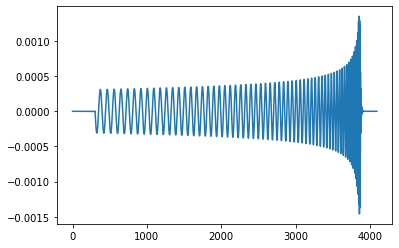

In [7]:
plt.plot(SIGNAL_DICT[0][0])

# Configuration

In [8]:
class Config:

    #frequently changed 
    model_name = 'TCNN'
    model_version = "main_82nd_V2_c16_sGW_vflip_sc01_PL" 
    model_module = 'ModelIafossV2'
    
    use_PL=False 
    pseudo_label_folder = "./PL_fold/"
    use_GW=False #!!
    use_raw_wave=True #!!

    use_checkpoint = False
    prev_model_folder = None #!!
    use_lr_finder = False
    
    debug = False
    use_subset = False 
    subset_frac = 0.4

    #preproc related
    #augmentation
    vflip = True
    shuffle01 = True    
    
    time_shift = False
    time_stretch = False
    shuffle_channels = False  # need normalization first
    add_gaussian_noise = False # need normalization first
    timemask = False
    shift_channel = False    
    pitch_shift = False
    use_mixup = False
    mixup_alpha = 0.1
    cropping = False

    #logistic
    seed = 48
    target_size = 1
    target_col = 'target'
    n_fold = 5
    gdrive = './input/'
    kaggle_json_path = './kaggle/kaggle.json'
    output_dir = "./output_model/"
    
    #logger
    print_num_steps=350
    
    #training related
    train_folds = [0,1,2,3,4]
    epochs = 6
    batch_size = 256
    
    lr= 7e-3#2e-3
    weight_decay= 1e-4 #1e-4  # Optimizer, default value 0.01
    gradient_accumulation_steps=1 # Optimizer
    scheduler='cosineWithWarmUp' # warm up ratio 0.1 of total steps 

    # Add SWA
    use_swa = False
    swa_lr_ratio = 0 # in terms of max lr
    swa_start_step_epoch = 3
    swa_anneal_ratio =  999, # 999 means anneal til the end of the training


    #speedup
    num_workers=8
    non_blocking=False
    amp=True
    use_cudnn = True 
    use_tpu = False
    use_ram = False
    
    #CNN structure
    channels = 16
    reduction = 4.0
    stochastic_final_layer_proba = 0.5

# no need to change below
Config.swa_lr = Config.lr * Config.swa_lr_ratio

Config.model_output_folder = Config.output_dir + Config.model_version + "/"
if Config.prev_model_folder is not None:
    # !!
    Config.prev_model_folder = Config.output_dir + Config.prev_model_folder + "/"
else:
    Config.prev_model_folder = Config.model_output_folder 

if not os.path.exists(Config.output_dir):
    os.mkdir(Config.output_dir)
if not os.path.exists(Config.model_output_folder):
    os.mkdir(Config.model_output_folder)

torch.backends.cudnn.benchmark = Config.use_cudnn 
display(Config.model_output_folder)

'./output_model/main_82nd_V2_c16_sGW_vflip_sc01_PL/'

In [9]:
# run once for Fold 0, save it in RAM and then do experiments multiple times
# if Config.train_folds == [0]:
#     if Config.use_pseudo_label:
#         with open('fold_0_data_PL.npy', 'rb') as f:
#             fold_0_data_PL = np.load(f)
#     else:
#         with open('fold_0_data.npy', 'rb') as f:
#             fold_0_data = np.load(f)

In [10]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

save_object(class2dict(Config), Config.model_output_folder + "Config.pkl")

# Data path

In [11]:
def id_2_path(file_id: str, train=True) -> str:
    if train:
        return "./input/whiten-train/{}.npy".format(file_id)
    else:
        return "./input/whiten-test/{}.npy".format(file_id)

def id_2_path_wave(file_id: str, train=True) -> str:
    #!!
    if train:
        return "./input/train-float32/{}.npy".format(file_id)
    else:
        return "./input/test-float32/{}.npy".format(file_id)

In [12]:
train_df = pd.read_csv(Config.gdrive + '/training_labels.csv')
test_df = pd.read_csv(Config.gdrive + '/sample_submission.csv')

if Config.debug:
    Config.epochs = 1
    train_df = train_df.sample(n=50000, random_state=Config.seed).reset_index(drop=True)
    
if Config.use_subset:
    train_df = train_df.sample(frac=Config.subset_frac, random_state=Config.seed).reset_index(drop=True)

if Config.use_raw_wave:
    train_df['file_path'] = train_df['id'].apply(lambda x :id_2_path_wave(x))
    test_df['file_path'] = test_df['id'].apply(lambda x :id_2_path_wave(x,False))
else:
    train_df['file_path'] = train_df['id'].apply(lambda x :id_2_path(x))
    test_df['file_path'] = test_df['id'].apply(lambda x :id_2_path(x,False))

In [13]:
TRAIN_DATA = {}
if Config.use_ram:
    print("Use RAM to load train data")
    for i,path in tqdm(enumerate(train_df.file_path)):
        waves = np.load(path)
        TRAIN_DATA[path] = waves

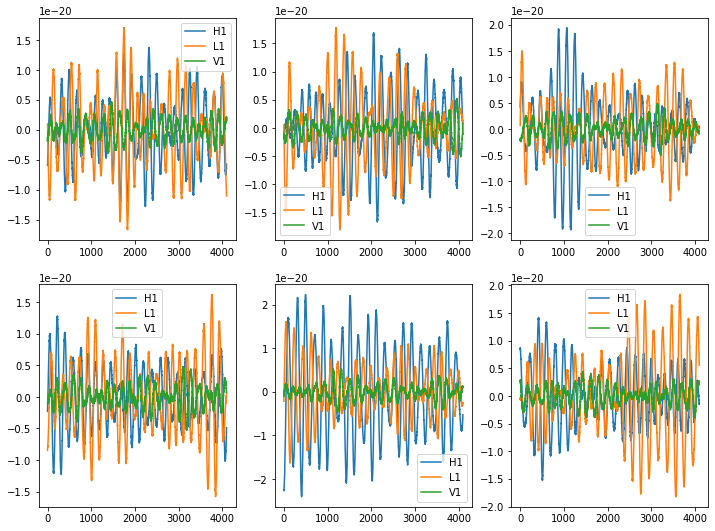

In [14]:
# checking magnitude of waves
num_files = 6
sites = ['H1',"L1","V1"]
input_file_paths = train_df['file_path'].values[:num_files]
plt.figure(figsize=(12,9))
for i,input_file_path in enumerate(input_file_paths[:num_files]):
    file_name = input_file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(input_file_path)
    plt.subplot(2,3,i+1)
    for j in range(3):
        plt.plot(waves[j], label=sites[j])
    plt.legend()

In [15]:
skf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
splits = skf.split(train_df, train_df["target"])
train_df['fold'] = -1
for fold, (train_index, valid_index) in enumerate(splits):
    train_df.loc[valid_index,"fold"] = fold
train_df.groupby('fold')['target'].apply(lambda s: s.value_counts(normalize=True))

fold   
0     0    0.500125
      1    0.499875
1     0    0.500125
      1    0.499875
2     0    0.500125
      1    0.499875
3     0    0.500125
      1    0.499875
4     0    0.500125
      1    0.499875
Name: target, dtype: float64

In [16]:
train_df

,id,target,file_path,fold
0,00000e74ad,1,./input/train-float32/00000e74ad.npy,3
1,00001f4945,0,./input/train-float32/00001f4945.npy,0
2,0000661522,0,./input/train-float32/0000661522.npy,4
3,00007a006a,0,./input/train-float32/00007a006a.npy,0
4,0000a38978,1,./input/train-float32/0000a38978.npy,4
...,...,...,...,...
559995,ffff9a5645,1,./input/train-float32/ffff9a5645.npy,3
559996,ffffab0c27,0,./input/train-float32/ffffab0c27.npy,1
559997,ffffcf161a,1,./input/train-float32/ffffcf161a.npy,2
559998,ffffd2c403,0,./input/train-float32/ffffd2c403.npy,1


# dataset

In [17]:
transform_list = []
if Config.add_gaussian_noise:
    transform_list.append(A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5))
if Config.time_shift:
    transform_list.append(A.Shift(min_fraction=-512*1.0/4096, max_fraction=-1*1.0/4096, p=0.5,rollover=False))#<0 means shift towards left,  fraction of total sound length
if Config.pitch_shift:
    transform_list.append(A.PitchShift(min_semitones=-1, max_semitones=1, p=0.5))
if Config.time_stretch:
    transform_list.append(A.TimeStretch(min_rate=0.98, max_rate=1.02,leave_length_unchanged=True, p=0.5))
if Config.timemask:
    transform_list.append(A.TimeMask(min_band_part=0.0, max_band_part=0.01, fade=False, p=0.5))#try 0.03 next time
train_transform = A.Compose(transform_list)
test_transform = A.Compose([])

class DataRetriever(Dataset):
    def __init__(self, paths, targets, transforms=None, synthetic=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms
        #!!
        if synthetic is not None:
            self.synthetic = synthetic
            self.synthetic_keys = list(self.synthetic.keys())
        else:
            self.synthetic = None
            self.synthetic_keys = None
        self.neg_idxes = [i for i, t in enumerate(targets) if t == 0]
                
            # saving Fold 0 data for later use
#         with open('fold_0_data_PL.npy', 'wb') as f:
#             np.save(f, self.data)


#           #reading data for fold 0 for fast iteration
#         if Config.train_folds == [0]:
#             if Config.use_pseudo_label:
#                 self.data = fold_0_data_PL
#             else:
#                 self.data = fold_0_data
#         else:
#             raise RuntimeError('wrong data!')
#             print(time.time()-start_time)


    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        target = self.targets[index]
        path = self.paths[index]
        if target > 0 and Config.use_GW: 
            path = self.paths[random.choice(self.neg_idxes)]                
        waves = TRAIN_DATA[path] if (Config.use_ram and path in TRAIN_DATA) else np.load(path)
        
        if Config.cropping:
            waves = waves[:,1792:3840+1]

        if Config.shuffle_channels:#nn.ChannelShuffle
            if np.random.random()<0.5:
                np.random.shuffle(waves)
        if Config.shuffle01:
            if np.random.random()<0.5:
                waves[[0,1]]=waves[[1,0]]
        if Config.vflip:
            if np.random.random()<0.5:
                waves = -waves
              
        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)

        if Config.use_raw_wave:
            #!!
            x = torch.FloatTensor(waves*1e20)
        else:
            x = torch.FloatTensor(waves)
        
        
        if target > 0 and Config.use_GW:
            #!!
            w = torch.FloatTensor((self.synthetic[random.choice(self.synthetic_keys)]))
            w = w * max(random.gauss(3.6,1),1)
            shift_place = 512+384-random.randrange(0,768)
            w = np.pad(w[:,shift_place:],[(0,0),(0,shift_place)],mode='constant')
            x += w
        target = torch.tensor(target,dtype=torch.float)#device=device,
        return (x, target)

class DataRetrieverTest(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms
        if Config.use_ram:
            array_shape = (len(self.paths),3,4096)
            self.data = np.zeros(array_shape,dtype=np.float32)
            for i,path in enumerate(self.paths):
                waves = np.load(path)
                self.data[i,:] = waves  

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index] 
        waves = TRAIN_DATA[path] if Config.use_ram else np.load(path)
        target = self.targets[index]
            
        if Config.cropping:
            waves = waves[:,1792:3840+1]
            
        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)

        if Config.use_raw_wave:
            #!!
            x = torch.FloatTensor(waves*1e20)
        else:
            x = torch.FloatTensor(waves)
        target = torch.tensor(target,dtype=torch.float)#device=device, 
        #print(path) 
        return (x, target)

# Models

In [18]:
def Model():
    model_name = Config.model_module 
    if model_name == 'Model1DCNN':
        model = Model1DCNN(Config.channels)
    elif model_name == 'Model1DCNNGEM':
        model = Model1DCNNGEM(Config.channels)
    elif model_name == 'ModelIafoss':
        model = ModelIafoss(Config.channels)
    elif model_name == 'ModelIafossV1':
        model = ModelIafossV1(Config.channels)
    elif model_name == 'ModelIafossV1SE':
        model = ModelIafossV1SE(Config.channels)
    elif model_name == 'ModelIafossV1CBAM':
        model = ModelIafossV1CBAM(Config.channels)
    elif model_name == 'ModelIafossV1Pool':
        model = ModelIafossV1Pool(Config.channels)
    elif model_name == 'ModelIafossV1GeM':
        model = ModelIafossV1GeM(Config.channels)
    elif model_name == 'ModelIafossV1GeMAll':
        model = ModelIafossV1GeMAll(Config.channels)
    elif model_name == 'ModelGeMx3':
        model = ModelGeMx3(Config.channels)
    elif model_name == 'ModelIafossV1GeMAllDeep':
        model = ModelIafossV1GeMAllDeep(Config.channels)
    elif model_name == 'DeepStochastic':
        model = DeepStochastic(Config.channels)
    elif model_name == 'Deeper':
        model = Deeper(Config.channels)
    elif model_name == 'Deeper2':
        model = Deeper2(Config.channels)
    elif model_name == 'ModelIafossV2':
        model = ModelIafossV2(Config.channels, use_raw_wave=Config.use_raw_wave)
    elif model_name == 'ModelIafossV2Mish':
        model = ModelIafossV2(Config.channels,act=Mish())
    elif model_name == 'ModelIafossV2Elu':
        model = ModelIafossV2(Config.channels,act=torch.nn.ELU())
    elif model_name == 'V2StochasticDepth':
        model = V2StochasticDepth(Config.channels)    
    return model

In [19]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = Model()#can possibly call random
get_n_params(model)

1581137

BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Sequential(
  (0): AdaptiveConcatPool1d(
    (ap): AdaptiveAvgPool1d(output_size=1)
    (mp): AdaptiveMaxPool1d(output_size=1)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): SiLU(inplace=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): SiLU(inplace=True)
  (10): Linear(in_features=256, out_features=1, bias=True)
)

# Util

In [20]:
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=Config.seed)

def get_scheduler(optimizer, train_size):
    epoch_step = train_size/Config.batch_size
    num_warmup_steps = int(0.1 * epoch_step * Config.epochs)
    num_training_steps = int(epoch_step * Config.epochs)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=num_warmup_steps, 
                                                num_training_steps=num_training_steps)      
    return scheduler

def mixed_criterion(loss_fn, pred, y_a, y_b, lam):
    return lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)

def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, requires_grad=False).to(x.device,non_blocking=Config.non_blocking)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Number of device:', torch.cuda.device_count())

#Additional Info when using cuda
# watch nvidia-smi
if device.type == 'cuda':
    print(torch.cuda.get_device_name(1))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Reserved:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Number of device: 2
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Reserved:    0.0 GB


# LR Finder

In [23]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), f'{Config.model_output_folder}/init_params.pt')

    def range_test(self, loader, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        for step, batch in enumerate(loader):
            if step == num_iter:
                break
            loss = self._train_batch(batch)
            lrs.append(lr_scheduler.get_last_lr()[0])
            #update lr
            lr_scheduler.step()
            if step > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
        #reset model to initial parameters
        model.load_state_dict(torch.load(f'{Config.model_output_folder}/init_params.pt'))
        return lrs, losses

    def _train_batch(self, batch):
        self.model.train()
        self.optimizer.zero_grad()
        scaler = GradScaler()
        X = batch[0].to(self.device,non_blocking=Config.non_blocking)
        targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
        
        if Config.use_mixup:
            (X_mix, targets_a, targets_b, lam) = mixup_data(
                X, targets, Config.mixup_alpha
            )
            with autocast(enabled=False):
                outputs = self.model(X_mix).squeeze()
                loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
        else:
            with autocast(enabled=False):
                outputs = self.model(X).squeeze()
                loss = self.criterion(outputs, targets)
        #loss.backward()
        scaler.scale(loss).backward()
        
        if Config.use_tpu:
            xm.optimizer_step(self.optimizer, barrier=True)  # Note: TPU-specific code! 
        else:
            scaler.step(self.optimizer)
            scaler.update()
#             self.optimizer.step()
        return loss.item()
    
                    
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)
    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

def plot_lr_finder(lrs, losses, skip_start = 0, skip_end = 0):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [24]:
if Config.use_lr_finder:
    START_LR = 1e-7
    model = Model()
    model.to(device,non_blocking=Config.non_blocking)
    #if torch.cuda.device_count() == 2:
    #    model = nn.DataParallel(model)
    optimizer = AdamW(model.parameters(), lr=START_LR, weight_decay=Config.weight_decay, amsgrad=False)
    criterion = torch_functional.binary_cross_entropy_with_logits

    train_data_retriever = DataRetriever(train_df['file_path'], train_df["target"].values)
    train_loader = DataLoader(train_data_retriever,
                                batch_size=Config.batch_size, 
                                shuffle=True, 
                                num_workers=Config.num_workers, pin_memory=True, drop_last=True)

In [25]:
%%time
if Config.use_lr_finder:
    try:
        END_LR = 10
        NUM_ITER = 150
        lr_finder = LRFinder(model, optimizer, criterion, device)
        lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)
    except (RuntimeError, KeyboardInterrupt) as e:
        del model, optimizer, criterion, train_data_retriever, train_loader, lr_finder
        gc.collect()
        torch.cuda.empty_cache() 
        print(e)

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 6.91 µs


In [26]:
if Config.use_lr_finder:
    plot_lr_finder(lrs[:-18], losses[:-18])

# Trainer

In [27]:
def get_swa(model, optimizer):
    swa_model = AveragedModel(model)
    train_size = int(train_df.shape[0] / Config.n_fold * (Config.n_fold-1))
    epoch_step = train_size/Config.batch_size        
    swa_start_step =  epoch_step * Config.swa_start_step_epoch
    swa_scheduler = torch.optim.swa_utils.SWALR(optimizer,
                                                anneal_strategy="cos", 
                                                anneal_epochs=int(epoch_step * (Config.epochs-1)), 
                                                swa_lr=Config.swa_lr)
    return swa_model, swa_scheduler

def do_swa_scheduler(step, swa_scheduler):
    if (swa_scheduler is not None) and (step >= int(Config.swa_start_step_epoch * len(train_df) * (1 - 1/Config.n_fold))//Config.batch_size  ):
        return True
    else:
        return False

In [28]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        scheduler,
        valid_labels,
        best_valid_score,
        fold,
        swa_model=None,
        swa_scheduler=None,
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.best_valid_score = best_valid_score
        self.valid_labels = valid_labels
        self.fold = fold

        self.swa_model = swa_model
        self.swa_scheduler = swa_scheduler
        self.step = 0 # for swa

    
    def fit(self, epochs, train_loader, valid_loader, save_path): 
        train_losses = []
        valid_losses = []
        for n_epoch in range(epochs):
            start_time = time.time()
            print('Epoch: ', n_epoch)
            train_loss, train_preds = self.train_epoch(train_loader)
            valid_loss, valid_preds = self.valid_epoch(valid_loader, self.model)

            if self.swa_model is not None:
                if n_epoch >= Config.swa_start_step_epoch:
                    print(f"Epoch {n_epoch}, update swa model")
                    self.swa_model.update_parameters(self.model)


            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(valid_loss)
            valid_score = get_score(self.valid_labels, valid_preds)            

            if self.best_valid_score < valid_score:
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path+f'best_model.pth', train_preds, valid_preds)

            print('train_loss: ',train_loss)
            print('valid_loss: ',valid_loss)
            print('valid_score: ',valid_score)
            print('best_valid_score: ',self.best_valid_score)
            print('time used: ', time.time()-start_time)

            wandb.log({f"[fold{self.fold}] epoch": n_epoch+1, 
                      f"[fold{self.fold}] avg_train_loss": train_loss, 
                      f"[fold{self.fold}] avg_val_loss": valid_loss,
                      f"[fold{self.fold}] val_score": valid_score})        
        # save swa
        if self.swa_model is not None:
            update_bn(train_loader, self.swa_model, device=self.device)
            valid_loss_swa, valid_preds_swa = self.valid_epoch(valid_loader, self.swa_model)
            valid_score_swa = get_score(self.valid_labels, valid_preds_swa)
            wandb.log({f"[fold{self.fold}] avg_val_loss_swa": valid_loss_swa, 
                      f"[fold{self.fold}] val_score_swa": valid_score_swa}) 
            print("SWA: Valid Loss {:.5f}, Valid Score {:.5f}".format(valid_loss_swa, valid_score_swa))
            # update batch normalization
            save_dict = {
                "swa_model_state_dict" : self.swa_model.state_dict(),                
                "swa_scheduler" : self.swa_scheduler.state_dict(),
                "valid_loss_swa" : valid_loss_swa,
                "valid_score_swa" : valid_score_swa,
            }
            torch.save(save_dict, save_path + f'swa_model.pth')        
            
    def train_epoch(self, train_loader):
        if Config.amp:
            scaler = GradScaler()
        self.model.train()
        losses = []
        train_loss = 0
        # preds = []
        for step, batch in enumerate(train_loader, 1):
            self.step += 1
            self.optimizer.zero_grad()
            X = batch[0].to(self.device,non_blocking=Config.non_blocking)
            targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
            
            if Config.use_mixup:
                (X_mix, targets_a, targets_b, lam) = mixup_data(
                    X, targets, Config.mixup_alpha
                )
                with autocast(enabled=False):
                    outputs = self.model(X_mix).squeeze()
                    loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
            else:
                with autocast(enabled=False):
                    outputs = self.model(X).squeeze()
                    loss = self.criterion(outputs, targets)
                    
            if Config.gradient_accumulation_steps > 1:
                loss = loss / Config.gradient_accumulation_steps
            scaler.scale(loss).backward()
          
            if (step) % Config.gradient_accumulation_steps == 0:
                scaler.step(self.optimizer)
                scaler.update()
            

            if not do_swa_scheduler(self.step, self.swa_scheduler):
                self.scheduler.step()
                lr2 = self.scheduler.get_last_lr()[0]
            else:
                self.swa_scheduler.step()
                lr2 = self.swa_scheduler.get_last_lr()[0]


            loss2 = loss.detach()

            wandb.log({f"[fold{self.fold}] loss": loss2,
                       f"[fold{self.fold}] lr": lr2})            

            losses.append(loss2)
            train_loss += loss2

            if (step) % Config.print_num_steps == 0:
                train_loss = train_loss.item() #synch once per print_num_steps instead of once per batch
                print(f'[{step}/{len(train_loader)}] ', 
                      f'avg loss: ',train_loss/step,
                      f'inst loss: ', loss2.item())
                        
        return train_loss / step, None

    def valid_epoch(self, valid_loader, model):
        model.eval()      
        valid_loss = []
        preds = []
        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch[0].to(self.device,non_blocking=Config.non_blocking)
                targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
                outputs = model(X).squeeze()
                loss = self.criterion(outputs, targets)
                if Config.gradient_accumulation_steps > 1:
                    loss = loss / Config.gradient_accumulation_steps
                valid_loss.append(loss.detach().item())
                preds.append(outputs.sigmoid().to('cpu').numpy())
        predictions = np.concatenate(preds)
        return np.mean(valid_loss), predictions

    def save_model(self, n_epoch, save_path, train_preds, valid_preds):
        print("Save Model")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
                'scheduler': self.scheduler.state_dict(),
                'train_preds': train_preds,
                'valid_preds': valid_preds,
            },
            save_path,
        )

# Training loop

In [29]:
seed_torch(seed=Config.seed)

In [30]:
def generate_PL(fold, train_df,test_df):
    pseudo_label_df = pd.read_csv(Config.pseudo_label_folder + f"test_Fold_{fold}.csv")     
    if Config.use_raw_wave:
        pseudo_label_df['file_path'] = pseudo_label_df['id'].apply(lambda x :id_2_path_wave(x,False))
    else:
        pseudo_label_df['file_path'] = pseudo_label_df['id'].apply(lambda x :id_2_path(x,False))    
    pseudo_label_df["target"] = pseudo_label_df[f'preds_Fold_{fold}']
    test_df_2 = pseudo_label_df.copy()
    test_df_2['fold'] = -1
    PL_train_df = pd.concat([train_df, test_df_2]).reset_index(drop=True)
    PL_train_df.reset_index(inplace=True, drop=True)
    return PL_train_df

In [31]:
def training_loop(train_df, use_checkpoint=Config.use_checkpoint):
    kf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
    avg_best_valid_score = 0
    folds_val_score = []
    original_train_df = train_df.copy()#for PL
    for fold in range(Config.n_fold): 
        if Config.use_PL:
            PL_train_df = generate_PL(fold, original_train_df.copy(),test_df)   
            train_df = PL_train_df
        train_index, valid_index = train_df.query(f"fold!={fold}").index, train_df.query(f"fold=={fold}").index #fold means fold_valid 
        print('Fold: ', fold)
        if fold not in Config.train_folds:
            print("skip")
            continue
        train_X, valid_X = train_df.loc[train_index], train_df.loc[valid_index]
        valid_labels = train_df.loc[valid_index,Config.target_col].values
        oof = pd.DataFrame()
        oof['id'] = train_df.loc[valid_index,'id']
        oof['id'] = valid_X['id'].values.copy()
        oof = oof.reset_index()
        oof['preds'] = valid_labels
        oof.to_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv')

        print('training data samples, val data samples: ', len(train_X) ,len(valid_X))
        if Config.use_GW:
            #!!
            train_data_retriever = DataRetriever(train_X["file_path"].values, train_X["target"].values, transforms=train_transform,synthetic=SIGNAL_DICT)
        else:
            train_data_retriever = DataRetriever(train_X["file_path"].values, train_X["target"].values, transforms=train_transform)

        valid_data_retriever = DataRetrieverTest(valid_X["file_path"].values, valid_X["target"].values, transforms=test_transform)       
        
        train_loader = DataLoader(train_data_retriever,
                                  batch_size=Config.batch_size, 
                                  shuffle=True, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)
        valid_loader = DataLoader(valid_data_retriever, 
                                  batch_size=Config.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)

        model = Model()
        model.to(device,non_blocking=Config.non_blocking)
        #if torch.cuda.device_count() == 2:
        #    model = nn.DataParallel(model)
        optimizer = AdamW(model.parameters(), lr=Config.lr,eps=1e-08, weight_decay=Config.weight_decay, amsgrad=False) #eps to avoid NaN/Inf in training loss
        scheduler = get_scheduler(optimizer, len(train_X))
        swa_model, swa_scheduler = None, None
        best_valid_score = -np.inf
        if use_checkpoint:
            #!!
            model_folder = Config.model_output_folder if Config.prev_model_folder is None else Config.prev_model_folder
            print(f"Load Checkpoint from folder: {model_folder}")
            checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            best_valid_score = float(checkpoint['best_valid_score'])
        if Config.use_swa:
            print("Use SWA")
            swa_model, swa_scheduler = get_swa(model, optimizer)
        scheduler = get_scheduler(optimizer, len(train_X))
        
        
        criterion = torch_functional.binary_cross_entropy_with_logits
        

        trainer = Trainer(
            model, 
            device, 
            optimizer, 
            criterion,
            scheduler,
            valid_labels,
            best_valid_score,
            fold,
            swa_model,
            swa_scheduler
        )

        history = trainer.fit(
            epochs=Config.epochs, 
            train_loader=train_loader, 
            valid_loader=valid_loader,
            save_path=f'{Config.model_output_folder}/Fold_{fold}_',
        )
        folds_val_score.append(trainer.best_valid_score)
    wandb.finish()
    print('folds score:', folds_val_score)
    print("Avg: {:.5f}".format(np.mean(folds_val_score)))
    print("Std: {:.5f}".format(np.std(folds_val_score)))

# Weight & Bias Initialization

In [32]:
wandb.login(key="")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/.netrc


True

# Train

## Pretraining

In [65]:
%%time
Config.epochs = 2
Config.use_GW = True
Config.use_PL = False
Config.use_checkpoint = False
Config.use_swa = False
run = wandb.init(project="G2Net", name=Config.model_version + "_pretrain" , config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df.copy(),Config.use_checkpoint)
except (ValueError, RuntimeError, KeyboardInterrupt) as e:
    wandb.finish()    
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

wandb: ERROR Control-C detected -- Run data was not synced


Fold:  0
training data samples, val data samples:  448000 112000
Epoch:  0
[350/1750]  avg loss:  0.5997528512137277 inst loss:  0.4607737064361572


[fold0] loss,0.50899
[fold0] lr,0.001


[fold0] loss,██▇███▇▇▇▆▆▆▇▅▆▃▅▄▅▅▂▃▂▃▂▂▂▂▃▃▂▃▂▃▂▂▁▁▁▂
[fold0] lr,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████████



CPU times: user 1min 1s, sys: 15.8 s, total: 1min 17s
Wall time: 1min 18s


## Training

In [33]:
# %%time
Config.epochs = 6
Config.use_PL = True
Config.use_checkpoint = True
Config.use_GW = False
Config.use_swa = False

run_error = False
run = wandb.init(project="G2Net", name=Config.model_version, config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df.copy(),Config.use_checkpoint)
except (ValueError, RuntimeError, KeyboardInterrupt) as e:
    wandb.finish()
    run_error=True
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

Fold:  0
skip
Fold:  1
skip
Fold:  2
skip
Fold:  3
training data samples, val data samples:  674000 112000
Load Checkpoint from folder: ./output_model/main_82nd_V2_c16_sGW_vflip_sc01_PL/
Epoch:  0
[350/2633]  avg loss:  0.4309755597795759 inst loss:  0.39097654819488525
[700/2633]  avg loss:  0.4222847638811384 inst loss:  0.37013253569602966
[1050/2633]  avg loss:  0.41821765718005954 inst loss:  0.4016340970993042
[1400/2633]  avg loss:  0.4163144792829241 inst loss:  0.3964075446128845
[1750/2633]  avg loss:  0.41506452287946427 inst loss:  0.41499608755111694
[2100/2633]  avg loss:  0.4135993884858631 inst loss:  0.3914918899536133
[2450/2633]  avg loss:  0.4127164879623724 inst loss:  0.4088508188724518
Save Model
train_loss:  tensor(0.4123, device='cuda:1')
valid_loss:  0.42440014138613663
valid_score:  0.872757114655738
best_valid_score:  0.872757114655738
time used:  582.3987035751343
Epoch:  1
[350/2633]  avg loss:  0.4017556326729911 inst loss:  0.43669742345809937
[700/2633]

[fold3] avg_train_loss,0.38416
[fold3] avg_val_loss,0.39677
[fold3] epoch,6
[fold3] loss,0.41883
[fold3] lr,0.0
[fold3] val_score,0.88259
[fold4] avg_train_loss,0.38686
[fold4] avg_val_loss,0.39772
[fold4] epoch,6
[fold4] loss,0.38585
[fold4] lr,0.0


[fold3] avg_train_loss,█▅▄▃▂▁
[fold3] avg_val_loss,█▆▄▁▂▁
[fold3] epoch,▁▂▄▅▇█
[fold3] loss,█▆▇▅▄▅▆▄▄▅▆▄▆▅▆▁▆▆▅▄▆▄▅▃▃▅▄▆▄▄▄▃▃▃▇▄▄▄▁▄
[fold3] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold3] val_score,▁▆▇▆██
[fold4] avg_train_loss,█▅▄▃▂▁
[fold4] avg_val_loss,▃█▂▁▂▁
[fold4] epoch,▁▂▄▅▇█
[fold4] loss,▆▆█▄▅▅▇▅▂▃▅▄▅▄▃▅▃▄▃▃▄▂▇▂▁▄▁▂▂▂▁▄▂▃▂▃▁▃▃▄
[fold4] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


folds score: [0.8825857960736021, 0.8811434645102421]
Avg: 0.88186
Std: 0.00072


# Bug

In [34]:
# retrain fold 1,2
Config.train_folds = [1,2]
Config.epochs = 2
Config.use_GW = True
Config.use_PL = False
Config.use_checkpoint = False
run = wandb.init(project="G2Net", name=Config.model_version + "_pretrain" , config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df.copy(),Config.use_checkpoint)
except (ValueError, RuntimeError, KeyboardInterrupt) as e:
    wandb.finish()    
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

Fold:  0
skip
Fold:  1
training data samples, val data samples:  448000 112000
Epoch:  0
[350/1750]  avg loss:  0.5482647705078125 inst loss:  0.5389760732650757
[700/1750]  avg loss:  0.5128021240234375 inst loss:  0.44510766863822937
[1050/1750]  avg loss:  0.4977411179315476 inst loss:  0.5369569659233093
[1400/1750]  avg loss:  0.48705814906529016 inst loss:  0.44739216566085815
[1750/1750]  avg loss:  0.4786155482700893 inst loss:  0.49801668524742126
Save Model
train_loss:  0.4786155482700893
valid_loss:  0.4659000120750845
valid_score:  0.8430031904428015
best_valid_score:  0.8430031904428015
time used:  391.1699206829071
Epoch:  1
[350/1750]  avg loss:  0.4411916242327009 inst loss:  0.40609151124954224
[700/1750]  avg loss:  0.43676413399832587 inst loss:  0.4666467308998108
[1050/1750]  avg loss:  0.4343990652901786 inst loss:  0.42360779643058777
[1400/1750]  avg loss:  0.43209599086216516 inst loss:  0.45467907190322876
[1750/1750]  avg loss:  0.43009776088169643 inst loss:

[fold1] avg_train_loss,0.4301
[fold1] avg_val_loss,0.46385
[fold1] epoch,2
[fold1] loss,0.47111
[fold1] lr,0.0
[fold1] val_score,0.84594
[fold2] avg_train_loss,0.43035
[fold2] avg_val_loss,0.45756
[fold2] epoch,2
[fold2] loss,0.46876
[fold2] lr,0.0


[fold1] avg_train_loss,█▁
[fold1] avg_val_loss,█▁
[fold1] epoch,▁█
[fold1] loss,█▄▃▂▃▂▄▃▃▃▃▂▃▃▂▂▂▄▁▃▃▂▃▃▂▂▁▁▂▂▂▂▂▁▄▂▂▃▂▃
[fold1] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold1] val_score,▁█
[fold2] avg_train_loss,█▁
[fold2] avg_val_loss,█▁
[fold2] epoch,▁█
[fold2] loss,█▅▄▃▂▄▂▃▃▂▃▃▂▃▄▃▃▁▃▂▂▃▃▂▂▁▂▂▂▂▁▂▁▂▂▃▁▂▂▂
[fold2] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


folds score: [0.845944547450616, 0.8481522596421692]
Avg: 0.84705
Std: 0.00110


In [35]:
# %%time
Config.train_folds = [1,2]
Config.epochs = 6
Config.use_PL = True
Config.use_checkpoint = True
Config.use_GW = False
Config.use_swa = False

run_error = False
run = wandb.init(project="G2Net", name=Config.model_version, config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df.copy(),Config.use_checkpoint)
except (ValueError, RuntimeError, KeyboardInterrupt) as e:
    wandb.finish()
    run_error=True
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

Fold:  0
skip
Fold:  1
training data samples, val data samples:  674000 112000
Load Checkpoint from folder: ./output_model/main_82nd_V2_c16_sGW_vflip_sc01_PL/
Epoch:  0
[350/2633]  avg loss:  0.4309885951450893 inst loss:  0.37467652559280396
[700/2633]  avg loss:  0.4201111275809152 inst loss:  0.4037328362464905
[1050/2633]  avg loss:  0.41719642275855656 inst loss:  0.39339831471443176
[1400/2633]  avg loss:  0.4153073992047991 inst loss:  0.37072569131851196
[1750/2633]  avg loss:  0.41401953125 inst loss:  0.43175622820854187
[2100/2633]  avg loss:  0.4124234735398066 inst loss:  0.4121675193309784
[2450/2633]  avg loss:  0.4114999701052296 inst loss:  0.41421109437942505
Save Model
train_loss:  tensor(0.4111, device='cuda:1')
valid_loss:  0.4505674731513681
valid_score:  0.8716528944017752
best_valid_score:  0.8716528944017752
time used:  579.42112159729
Epoch:  1
[350/2633]  avg loss:  0.4032002476283482 inst loss:  0.4235500395298004
[700/2633]  avg loss:  0.40209712437220985 i

[fold1] avg_train_loss,0.38356
[fold1] avg_val_loss,0.3981
[fold1] epoch,6
[fold1] loss,0.41042
[fold1] lr,0.0
[fold1] val_score,0.88078
[fold2] avg_train_loss,0.38097
[fold2] avg_val_loss,0.40091
[fold2] epoch,6
[fold2] loss,0.38469
[fold2] lr,0.0


[fold1] avg_train_loss,█▅▄▃▂▁
[fold1] avg_val_loss,█▄▁▃▃▁
[fold1] epoch,▁▂▄▅▇█
[fold1] loss,▇▄▆█▆▄▄▇▅▆▃▄▅▄▁▄▅▆▂▂▂▄▄▄▁▃▅▇▄▄▃▃▅▄▃▅▂▄▅▂
[fold1] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold1] val_score,▁▄▅▇██
[fold2] avg_train_loss,█▅▄▃▂▁
[fold2] avg_val_loss,█▂▆▁▂▂
[fold2] epoch,▁▂▄▅▇█
[fold2] loss,▆▃▃▄▆▆▅▂█▄▆▅▇▆▄▄▆▇▅▆▇▇▅▃▁▅▇▅▂▅▅▄▄▅▄▅▄▅▄▄
[fold2] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


folds score: [0.8807845158270935, 0.8804747790411532]
Avg: 0.88063
Std: 0.00015


# Error Handling

In [36]:
if run_error:
    sleep(120)
    jarviscloud.pause()

[autoreload of models failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreloa

# add TTA

In [68]:
def get_before_head(x, model):
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=False):
            shape = x.shape
            c = x.view(shape[0]*shape[1],-1)
            c = torch.cat([-c.flip(-1)[:,4096-2049:-1]+2*c[:,0].unsqueeze(-1),c,
                              -c.flip(-1)[:,1:2049]+2*c[:,-1].unsqueeze(-1)],1)
            avr_spec = model.avr_spec.repeat(shape[0],1).view(-1,model.avr_spec.shape[-1])
            x = torch.fft.ifft(torch.fft.fft(c*model.window)/avr_spec).real
            x = x.view(shape[0],shape[1],x.shape[-1])
            x = x[:,:,2048:-2048]
    x0 = [model.ex[0](x[:,0].unsqueeze(1)),model.ex[0](x[:,1].unsqueeze(1)),
          model.ex[1](x[:,2].unsqueeze(1))]
    x1 = [model.conv1[0](x0[0]),model.conv1[0](x0[1]),model.conv1[1](x0[2]),
          model.conv1[2](torch.cat([x0[0],x0[1],x0[2]],1))]
    x2 = torch.cat(x1,1)
    return model.conv2(x2)
    
def get_pred(loader, model):
    model.head[4].train()
    model.head[8].train()
    preds = []
    for step, batch in enumerate(loader, 1):
        if step % Config.print_num_steps == 0:
            print("step {}/{}".format(step, len(loader)))
        with torch.no_grad():
            X = batch[0].to(device,non_blocking=Config.non_blocking)
            x2 = get_before_head(X, model)
            preds_MC = [model.head(x2) for i in range(64)]
            outputs = torch.stack(preds_MC,0).mean(0)
            outputs = outputs.squeeze().sigmoid().cpu().detach().numpy()
            preds.append(outputs)
    predictions = np.concatenate(preds)
    return predictions

def get_tta_pred(df,model,**transforms):
    data_retriever = TTA(df['file_path'].values, df['target'].values, **transforms)
    loader = DataLoader(data_retriever, 
                            batch_size=Config.batch_size * 2, 
                            shuffle=False, 
                            num_workers=Config.num_workers, pin_memory=True, drop_last=False)
    return get_pred(loader,model)

In [69]:
def get_tta_df(df, model):
    df["tta_vflip"] = get_tta_pred(df,model,use_vflip=True)
    # df["tta_shift"] = get_tta_pred(df,model,time_shift=True)
    # df["tta_vflip_shift"] = get_tta_pred(df,model,use_vflip=True,time_shift=True)
    df["tta_shuffle01"] = get_tta_pred(df,model,shuffle01=True)
    # df["tta_vflip_shuffle01"] = get_tta_pred(df,model,use_vflip=True,shuffle01=True)
    # df["tta_shift_shuffle01"] = get_tta_pred(df,model,time_shift=True,shuffle01=True)
    # df["tta_vflip_shift_shuffle01"] = get_tta_pred(df,model,use_vflip=True,time_shift=True,shuffle01=True)
    return df

In [70]:
model = Model()
oof_all = pd.DataFrame()
for fold in tqdm(Config.train_folds):
    oof = train_df.query(f"fold=={fold}").copy()
    oof['preds'] = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')['valid_preds']
    oof['file_path'] = train_df['id'].apply(lambda x :id_2_path_wave(x))
    # display(oof)    
    if Config.use_swa:
        swa_model = AveragedModel(model)
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_swa_model.pth')
        model = swa_model
        model.load_state_dict(checkpoint['model_swa_state_dict'])
    else:
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        
    model.to(device=device,non_blocking=Config.non_blocking)
    #if torch.cuda.device_count() == 2:
    #    model = nn.DataParallel(model)
    model.eval()
    oof = get_tta_df(oof, model)
    oof.to_csv(Config.model_output_folder + f"/oof_Fold_{fold}.csv", index=False)
    oof_all = pd.concat([oof_all,oof])

In [71]:
print("Original:",roc_auc_score(oof_all['target'], oof_all['preds']))

for col in oof.columns:
    if "tta" in col:
        print(col,roc_auc_score(oof_all['target'], oof_all[col]))

avg_cols = [col for col in oof_all.columns if "tta" in col or "preds" in col]
oof_all['avg']=oof_all[avg_cols].mean(axis=1)
print("preds_tta_avg:",roc_auc_score(oof_all['target'], oof_all['avg']))
CV_SCORE = roc_auc_score(oof_all['target'], oof_all['avg'])
oof_all.to_csv(Config.model_output_folder + "/oof_all.csv", index=False)
oof_all[['id','fold','avg']].rename(columns={'id':'id','fold':'fold','avg':'prediction'}).to_csv(Config.model_output_folder + "/oof_final.csv", index=False)

Original: 0.8813320316202418
tta_vflip 0.8812914000998449
tta_shuffle01 0.8813289773598468
preds_tta_avg: 0.8815615002315222


In [72]:
oof_all.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['avg']))

fold
0    0.882199
1    0.881066
2    0.880728
3    0.882769
4    0.881391
dtype: float64

In [73]:
oof_all.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['avg'])).mean()

0.8816305529335422

<AxesSubplot:>

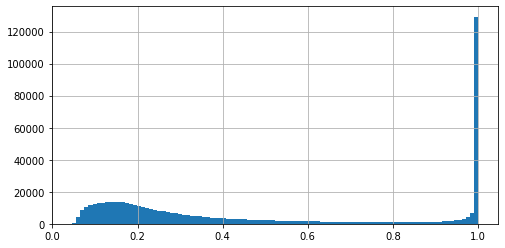

In [74]:
oof_all['avg'].hist(bins=100, figsize=(8,4))

In [75]:
%%time 
test_df['target'] = 0  
model = Model()
test_avg = test_df[['id', 'target']].copy()
test_avg_rank = test_df[['id', 'target']].copy()
count = 0
for fold in tqdm(Config.train_folds):
    test_df2 = test_df.copy()
    if Config.use_swa:
        swa_model = AveragedModel(model)
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_swa_model.pth')
        model = swa_model
        model.load_state_dict(checkpoint['model_swa_state_dict'])
    else:
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])

    model.to(device=device,non_blocking=Config.non_blocking)
    #if torch.cuda.device_count() == 2:
    #    model = nn.DataParallel(model)
    model.eval()
    test_df2['preds'+f'_Fold_{fold}'] = get_tta_pred(test_df2,model)
    test_df2 = get_tta_df(test_df2, model)
    test_df2.to_csv(Config.model_output_folder + f"/test_Fold_{fold}.csv", index=False)
    for col in test_df2.columns:
        if "tta" in col or 'preds' in col: 
            count+=1
            test_avg['target'] += test_df2[col]
            test_avg_rank['target'] += test_df2[col].rank(pct=True)
test_avg['target'] /= count
test_avg_rank['target'] /= count

step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442
step 350/442

CPU times: user 9min 5s, sys: 2min 37s, total: 11min 43s
Wall time: 10min 51s


count    226000.000000
mean          0.473130
std           0.348724
min           0.064974
25%           0.178883
50%           0.308362
75%           0.944317
max           1.000000
Name: target, dtype: float64

<AxesSubplot:>

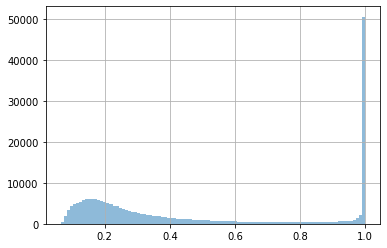

In [76]:
display(test_avg["target"].describe())
test_avg['target'].hist(bins=100, alpha=.5)

In [77]:
assert test_avg['target'].isna().sum() == 0

In [78]:
test_avg[['id', 'target']].to_csv(Config.model_output_folder + f"/submission_CV{CV_SCORE * 1e5:.0f}.csv", index=False)
test_avg_rank[['id', 'target']].to_csv(Config.model_output_folder + f"/submission_CV{CV_SCORE * 1e5:.0f}_rank.csv", index=False)
print(Config.model_output_folder + f"/submission_CV{CV_SCORE * 1e5:.0f}.csv")

./output_model/main_82nd_V2_c16_sGW_vflip_sc01_PL//submission_CV88156.csv


In [79]:
test_avg[['id', 'target']]

,id,target
0,00005bced6,0.999981
1,0000806717,0.949283
2,0000ef4fe1,0.301550
3,00020de251,0.950649
4,00024887b5,0.117942
...,...,...
225995,ffff4125f1,0.206387
225996,ffff9d32a6,0.258170
225997,ffff9f4c1f,0.240307
225998,ffffa19693,0.999975


In [ ]:
# test_avg[['id', 'target']].to_csv("./submission.csv", index=False)
# !mkdir -p ~/.kaggle/ && cp $Config.kaggle_json_path ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions submit -c g2net-gravitational-wave-detection -f ./submission.csv -m $Config.model_version

In [ ]:
# test_avg

# Pause

In [ ]:
%%javascript
import Ipython
IPython.notebook.save_notebook()

In [ ]:

sleep(120)

In [ ]:

jarviscloud.pause()